In [17]:
import json
import os
import requests
import warnings
from urllib.request import urlretrieve
import scanpy as sc
import anndata
import pandas as pd
import anndata as ad
import re
import scvi
import pickle
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import numpy as np


In [2]:
KPMP_SN_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/kpmp-sn-raw-rnaseq.h5ad')
HuBMAP_LK_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/LK_raw_updated_2025_june.h5ad')
HuBMAP_RK_raw=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/RK_raw_updated_2025_june.h5ad')

In [3]:
HuBMAP_RK_raw.var.index = HuBMAP_RK_raw.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))
HuBMAP_LK_raw.var.index = HuBMAP_LK_raw.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))

In [4]:
df = pd.read_csv("outer-cortex-datasets.csv")

# Extract IDs only from HuBMAP URLs
ids = []
for url in df["dataset"].astype(str):
    if "hubmapconsortium" in url:        # keep only HuBMAP
        entity_id = url.strip().split("/")[-1]
        ids.append(entity_id)

        
ids = (
    df.loc[df["dataset"].astype(str).str.contains("hubmapconsortium", na=False), "dataset"]
      .astype(str)
      .str.strip()
      .str.split("/")
      .str[-1]
      .tolist()
)

# subset: keep LK cells whose obs['dataset'] is in ids
adata_cortex_LK = HuBMAP_LK_raw[HuBMAP_LK_raw.obs["dataset"].isin(ids)].copy()
adata_cortex_RK = HuBMAP_RK_raw[HuBMAP_RK_raw.obs["dataset"].isin(ids)].copy()

In [5]:
adata_cortex_RK

AnnData object with n_obs × n_vars = 1272174 × 60286
    obs: 'uuid', 'hubmap_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'predicted_CLID', 'predicted_label', 'cl_match_type', 'prediction_score'
    var: 'hugo_symbol'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [6]:
Hubmap_shared = {
    "cell_id": "cell_id", 
    "predicted_CLID": "cl_id",
    "predicted_label": "cell_type",
    "n_genes": "gene_count",
    "age": "age",
    "sex": "sex",
    "race": "race",
    "hubmap_id":"library_id"
}
HubMap_var_shared = {
    "hugo_symbol": "feature_name"
}

In [7]:
adata_cortex_LK.obs['as_id'] = "UBERON:0002113"
adata_cortex_LK.obs['disease'] = "normal"
adata_cortex_LK.obs['consortium'] = 'HuBMAP'
adata_cortex_RK.obs['as_id'] = "UBERON:0002113"
adata_cortex_RK.obs['disease'] = "normal"
adata_cortex_RK.obs['consortium'] = 'HuBMAP'

adata_cortex_LK.obs.rename(columns=Hubmap_shared, inplace=True)
adata_cortex_LK.var.rename(columns=HubMap_var_shared, inplace=True)
    
adata_cortex_RK.obs.rename(columns=Hubmap_shared, inplace=True)
adata_cortex_RK.var.rename(columns=HubMap_var_shared, inplace=True)

In [8]:
kpmp_subset=KPMP_SN_raw[KPMP_SN_raw.obs['tissue']== 'cortex of kidney']
kpmp_subset=kpmp_subset[kpmp_subset.obs['disease']== 'normal']

In [9]:
standard = {
    'kidney interstitial alternatively activated macrophage',
    'kidney distal convoluted tubule epithelial cell',
    'epithelial cell of proximal tubule',
    'T cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct intercalated cell',
    'kidney interstitial fibroblast',
    'kidney connecting tubule epithelial cell',
    'kidney collecting duct principal cell',
    'endothelial cell',
    'B cell',
    'mature NK T cell',
    'mononuclear phagocyte',
    'podocyte',
    'parietal epithelial cell',
    'mast cell',
    'plasmacytoid dendritic cell, human',
    'plasma cell',
    'non-classical monocyte',
    'conventional dendritic cell',
    'kidney loop of Henle thin descending limb epithelial cell',
    'renal interstitial pericyte',
    'kidney loop of Henle thin ascending limb epithelial cell',
    'neutrophil',
    'papillary tips cell',
    'neural cell',
}

mapping = {
    # PT segments -> PT
    'epithelial cell of proximal tubule segment 1': 'epithelial cell of proximal tubule',
    'epithelial cell of proximal tubule segment 2': 'epithelial cell of proximal tubule',
    'epithelial cell of proximal tubule segment 3': 'epithelial cell of proximal tubule',

    # DCT early/late -> DCT
    'epithelial cell of early distal convoluted tubule': 'kidney distal convoluted tubule epithelial cell',
    'epithelial cell of late distal convoluted tubule': 'kidney distal convoluted tubule epithelial cell',

    # TAL variants -> TAL
    'kidney loop of Henle cortical thick ascending limb epithelial cell':
        'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney loop of Henle medullary thick ascending limb epithelial cell':
        'kidney loop of Henle thick ascending limb epithelial cell',

    # Descending thin limb variants -> thin descending limb
    'kidney loop of Henle short descending thin limb epithelial cell':
        'kidney loop of Henle thin descending limb epithelial cell',
    'kidney loop of Henle long descending thin limb inner medulla epithelial cell':
        'kidney loop of Henle thin descending limb epithelial cell',
    'kidney loop of Henle long descending thin limb outer medulla epithelial cell':
        'kidney loop of Henle thin descending limb epithelial cell',

    # Collecting duct principal variants -> collecting duct principal
    'kidney cortex collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney outer medulla collecting duct principal cell': 'kidney collecting duct principal cell',
    'kidney inner medulla collecting duct principal cell': 'kidney collecting duct principal cell',

    # Collecting duct intercalated variants -> collecting duct intercalated
    'kidney cortex collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney outer medulla collecting duct intercalated cell': 'kidney collecting duct intercalated cell',
    'kidney connecting tubule alpha-intercalated cell': 'kidney collecting duct intercalated cell',  # if you prefer CD-IC
    # If you prefer CNT-IC instead, comment the line above and use:
    # 'kidney connecting tubule alpha-intercalated cell': 'kidney connecting tubule epithelial cell',

    # Connecting tubule principal -> connecting tubule epithelial
    'kidney connecting tubule principal cell': 'kidney connecting tubule epithelial cell',
}


def map_cell_type(adata, standard, mapping, col="cell_type", keep_unknown=False):
    ct = adata.obs[col].astype(str)
    ct2 = ct.replace(mapping)

    if not keep_unknown:
        ct2 = ct2.where(ct2.isin(standard), pd.NA)

    adata.obs[col] = ct2
    return adata

map_cell_type(adata_cortex_RK,mapping=mapping,standard=standard)
map_cell_type(adata_cortex_LK,mapping=mapping,standard=standard)

AnnData object with n_obs × n_vars = 328483 × 60286
    obs: 'uuid', 'library_id', 'age', 'sex', 'height', 'weight', 'bmi', 'cause_of_death', 'race', 'barcode', 'dataset', 'azimuth_label', 'azimuth_id', 'cl_id', 'cell_type', 'cl_match_type', 'prediction_score', 'as_id', 'disease', 'consortium'
    var: 'feature_name'
    uns: 'annotation_metadata', 'cell_type_counts', 'creation_date_time', 'datasets', 'uuid'
    obsm: 'X_spatial'

In [10]:
len(list(adata_cortex_RK.obs['cell_type'].unique()))

24

In [11]:
len(list(adata_cortex_LK.obs['cell_type'].unique()))

24

In [12]:
len(list(kpmp_subset.obs['cell_type'].unique()))

26

In [13]:
common = kpmp_subset.var_names.intersection(adata_cortex_LK.var_names).intersection(adata_cortex_RK.var_names)

def get_sym(a):
    if "feature_name" in a.var: return a.var.loc[common, "feature_name"].astype("string")
    if "gene_name" in a.var:    return a.var.loc[common, "gene_name"].astype("string")
    return pd.Series(pd.NA, index=common, dtype="string")

sym = get_sym(kpmp_subset).fillna(get_sym(adata_cortex_LK)).fillna(get_sym(adata_cortex_RK))
# fallback to var_names if still NA
sym = sym.fillna(pd.Series(common.astype(str), index=common, dtype="string"))

# attach the unified gene_symbol to each dataset BEFORE concat
kpmp2 = kpmp_subset[:, common].copy()
lk2   = adata_cortex_LK[:, common].copy()
rk2   = adata_cortex_RK[:, common].copy()

for a in (kpmp2, lk2, rk2):
    a.var["gene_symbol"] = sym.loc[a.var_names].astype(str)

adata_combined = ad.concat(
    [kpmp2, lk2, rk2],
    join="inner",
    label="batch_combine",
    keys=["KPMP","HuBMAP_LK","HuBMAP_RK"],
    merge="same",   # now it's identical across all three, so "same" is safe
)

In [14]:
sc.pp.filter_cells(adata_combined, min_genes=200)
sc.pp.filter_genes(adata_combined, min_cells=3)

In [15]:
adata_combined

AnnData object with n_obs × n_vars = 372163 × 35306
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'batch_combine', 'n_genes'
    var: 'gene_symbol', 'n_cells'

In [16]:
adata_combined.layers["counts"] = adata_combined.X.copy()

sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
sc.pp.scale(adata_combined, max_value=10)

In [17]:
adata_combined

AnnData object with n_obs × n_vars = 372163 × 35306
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'batch_combine', 'n_genes'
    var: 'gene_symbol', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts'

In [18]:
sc.pp.highly_variable_genes(
    adata_combined,
    n_top_genes=3000,
    batch_key='library_id'
)

# # Subset to HVGs
adata_combined = adata_combined[:, adata_combined.var['highly_variable']].copy()

/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:306: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessin

In [19]:
sc.pp.pca(adata_combined, n_comps=50)
adata_combined.obsm["Unintegrated"] = adata_combined.obsm["X_pca"]

In [20]:
sc.external.pp.harmony_integrate(adata_combined, key=['batch_combine','library_id'],
    max_iter_harmony=500)

2026-01-21 18:38:31,134 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-01-21 18:38:54,560 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-01-21 18:38:56,569 - harmonypy - INFO - Iteration 1 of 500
2026-01-21 18:42:10,338 - harmonypy - INFO - Iteration 2 of 500
2026-01-21 18:45:24,582 - harmonypy - INFO - Converged after 2 iterations


In [21]:
scvi.model.SCVI.setup_anndata(adata_combined, layer="counts",batch_key="batch_combine",                 # KPMP vs HuBMAP
    categorical_covariate_keys=["library_id"])
vae = scvi.model.SCVI(adata_combined, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata_combined.obsm["scVI"] = vae.get_latent_representation()
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_combined,
    labels_key="cell_type"
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata_combined.obsm["scANVI"] = lvae.get_latent_representation()

/home/wruopeng/.local/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/wruopeng/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sw/pkgs/arc/python3.10-anaconda/2023.03/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/wruopeng/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sw/pkgs/arc/python3.10-anaconda/20

Training:   0%|          | 0/21 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=21` reached.
/home/wruopeng/.local/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


ValueError: Making .obs["cell_type"] categorical failed. Expected categories: ['B cell' 'T cell' 'conventional dendritic cell' 'endothelial cell'
 'epithelial cell of proximal tubule'
 'kidney collecting duct intercalated cell'
 'kidney collecting duct principal cell'
 'kidney connecting tubule epithelial cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney interstitial alternatively activated macrophage'
 'kidney interstitial fibroblast'
 'kidney loop of Henle thick ascending limb epithelial cell'
 'kidney loop of Henle thin ascending limb epithelial cell'
 'kidney loop of Henle thin descending limb epithelial cell' 'mast cell'
 'mature NK T cell' 'mononuclear phagocyte' 'neural cell' 'neutrophil'
 'non-classical monocyte' 'papillary tips cell' 'parietal epithelial cell'
 'plasma cell' 'plasmacytoid dendritic cell, human' 'podocyte'
 'renal interstitial pericyte']. Received categories: Index(['B cell', 'T cell', 'conventional dendritic cell', 'endothelial cell',
       'epithelial cell of proximal tubule',
       'kidney collecting duct intercalated cell',
       'kidney collecting duct principal cell',
       'kidney connecting tubule epithelial cell',
       'kidney distal convoluted tubule epithelial cell',
       'kidney interstitial alternatively activated macrophage',
       'kidney interstitial fibroblast',
       'kidney loop of Henle thick ascending limb epithelial cell',
       'kidney loop of Henle thin ascending limb epithelial cell',
       'kidney loop of Henle thin descending limb epithelial cell',
       'mast cell', 'mature NK T cell', 'mononuclear phagocyte', 'neural cell',
       'neutrophil', 'non-classical monocyte', 'papillary tips cell',
       'parietal epithelial cell', 'plasma cell',
       'plasmacytoid dendritic cell, human', 'podocyte',
       'renal interstitial pericyte'],
      dtype='object'). 

In [23]:
adata_combined.obs["cell_type"] = (
    adata_combined.obs["cell_type"].astype("string").fillna("Unknown").astype("category")
)

lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_combined,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata_combined.obsm["scANVI"] = lvae.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


/home/wruopeng/.local/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/wruopeng/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sw/pkgs/arc/python3.10-anaconda/2023.03/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/wruopeng/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sw/pkgs/arc/python3.10-anaconda/20

Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [24]:
adata_combined.obsm["Harmony"] = adata_combined.obsm["X_pca_harmony"]

In [27]:
(adata_combined.obs["cell_type"] == "Unknown").sum()


24300

In [31]:

[c for c in adata_combined.obs.columns if isinstance(adata_combined.obs[c].dtype, pd.StringDtype)]
[c for c in adata_combined.var.columns if isinstance(adata_combined.var[c].dtype, pd.StringDtype)]



[]

In [33]:
ad.settings.allow_write_nullable_strings = True

adata_combined.write('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/M2-git-kpmp-hubmap-cortex-normal-3000-hvg.h5ad')

In [34]:
bm = Benchmarker(
    adata_combined,
    batch_key="batch_combine",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=["Unintegrated", "Harmony", "scVI", "scANVI"],
    n_jobs=8,
)

In [35]:
bm.benchmark()

/home/wruopeng/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:  40%|████      | 4/10 [02:13<02:44, 27.40s/it, Batch correction: bras]     2026-01-21 19:25:51.886891: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2026-01-21 19:25:52.945995: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid co

INFO     endothelial cell consists of a single batch or is too small. Skip.                                        
INFO     kidney interstitial alternatively activated macrophage consists of a single batch or is too small. Skip.  
INFO     neural cell consists of a single batch or is too small. Skip.                                             



Metrics:  70%|███████   | 7/10 [07:33<05:10, 103.53s/it, Batch correction: graph_connectivity]/home/wruopeng/.local/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  25%|██▌       | 1/4 [07:35<22:45, 455.28s/it]tch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [02:15<00:51, 12.81s/it, Batch correction: kbet_per_label]

INFO     endothelial cell consists of a single batch or is too small. Skip.                                        
INFO     kidney interstitial alternatively activated macrophage consists of a single batch or is too small. Skip.  
INFO     neural cell consists of a single batch or is too small. Skip.                                             



Metrics:  70%|███████   | 7/10 [06:50<04:55, 98.40s/it, Batch correction: graph_connectivity]/home/wruopeng/.local/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  50%|█████     | 2/4 [14:26<14:19, 429.61s/it]tch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [04:08<01:37, 24.33s/it, Batch correction: kbet_per_label]

INFO     endothelial cell consists of a single batch or is too small. Skip.                                        
INFO     kidney interstitial alternatively activated macrophage consists of a single batch or is too small. Skip.  
INFO     neural cell consists of a single batch or is too small. Skip.                                             



Metrics:  70%|███████   | 7/10 [08:24<04:59, 99.76s/it, Batch correction: graph_connectivity]/home/wruopeng/.local/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  75%|███████▌  | 3/4 [22:52<07:44, 464.35s/it]tch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [03:56<01:25, 21.50s/it, Batch correction: kbet_per_label]

INFO     endothelial cell consists of a single batch or is too small. Skip.                                        
INFO     kidney interstitial alternatively activated macrophage consists of a single batch or is too small. Skip.  
INFO     neural cell consists of a single batch or is too small. Skip.                                             



Metrics:  70%|███████   | 7/10 [08:28<05:10, 103.38s/it, Batch correction: graph_connectivity]/home/wruopeng/.local/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████████| 4/4 [31:22<00:00, 470.66s/it]tch correction: pcr_comparison]

                                                                                         

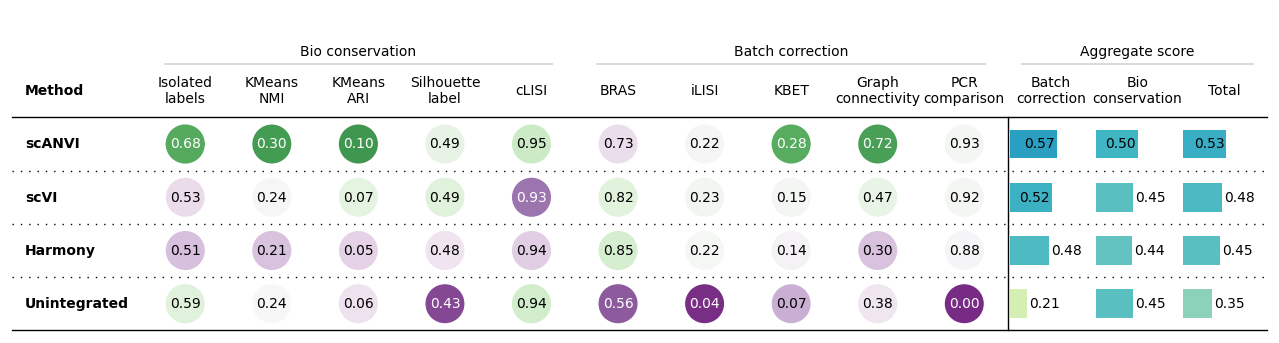

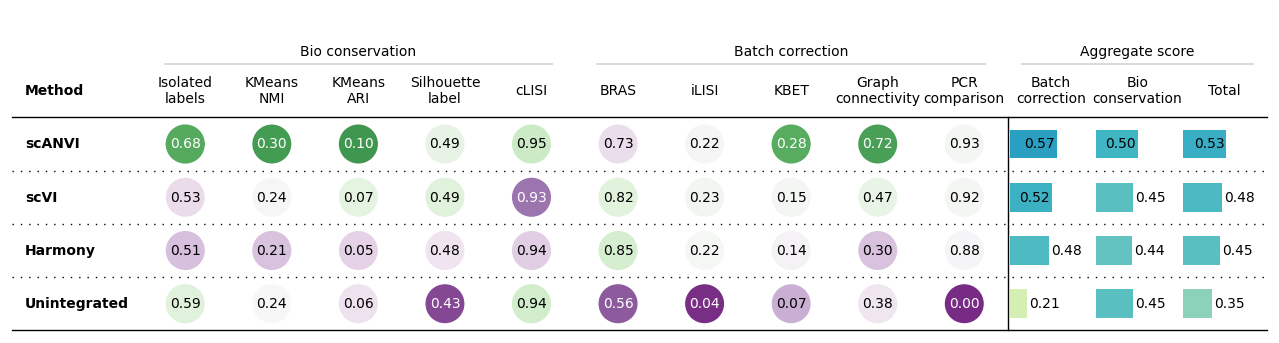

In [37]:
bm.plot_results_table(min_max_scale=False,save_dir="./git-res")
bm.plot_results_table(save_dir="./git-res")

In [38]:
df = bm.get_results(min_max_scale=False)
df.to_csv("scib_results_KPMP_HuBMAP.csv", index=False)

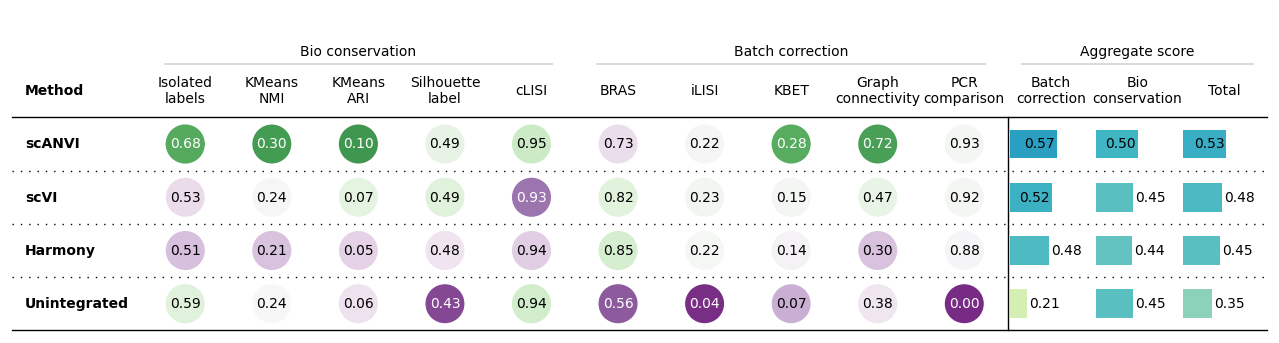

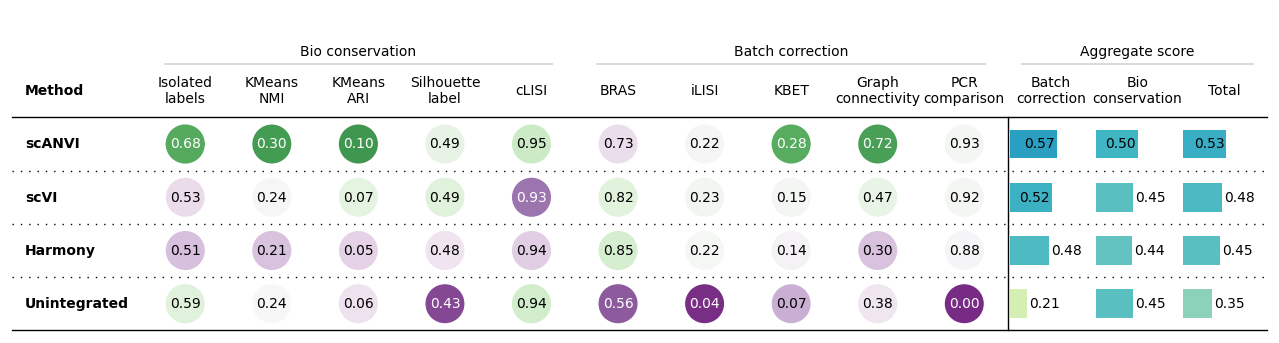

In [39]:
bm.plot_results_table(min_max_scale=False)
bm.plot_results_table()

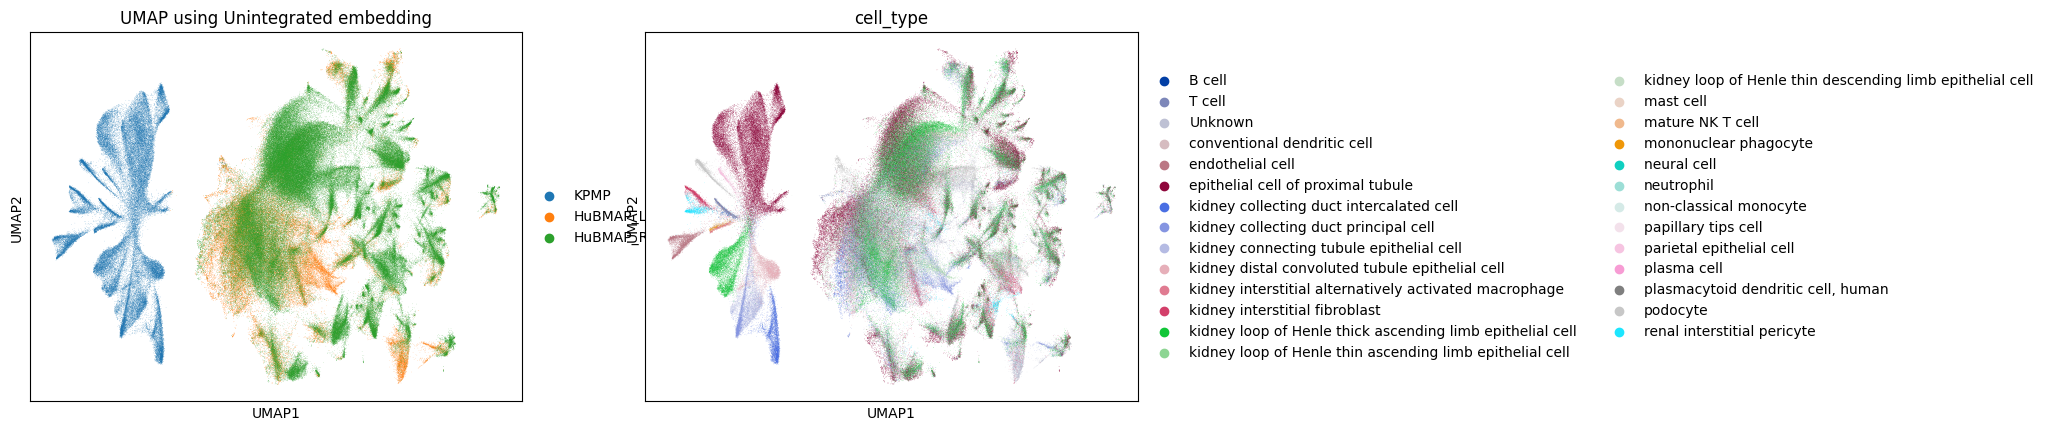

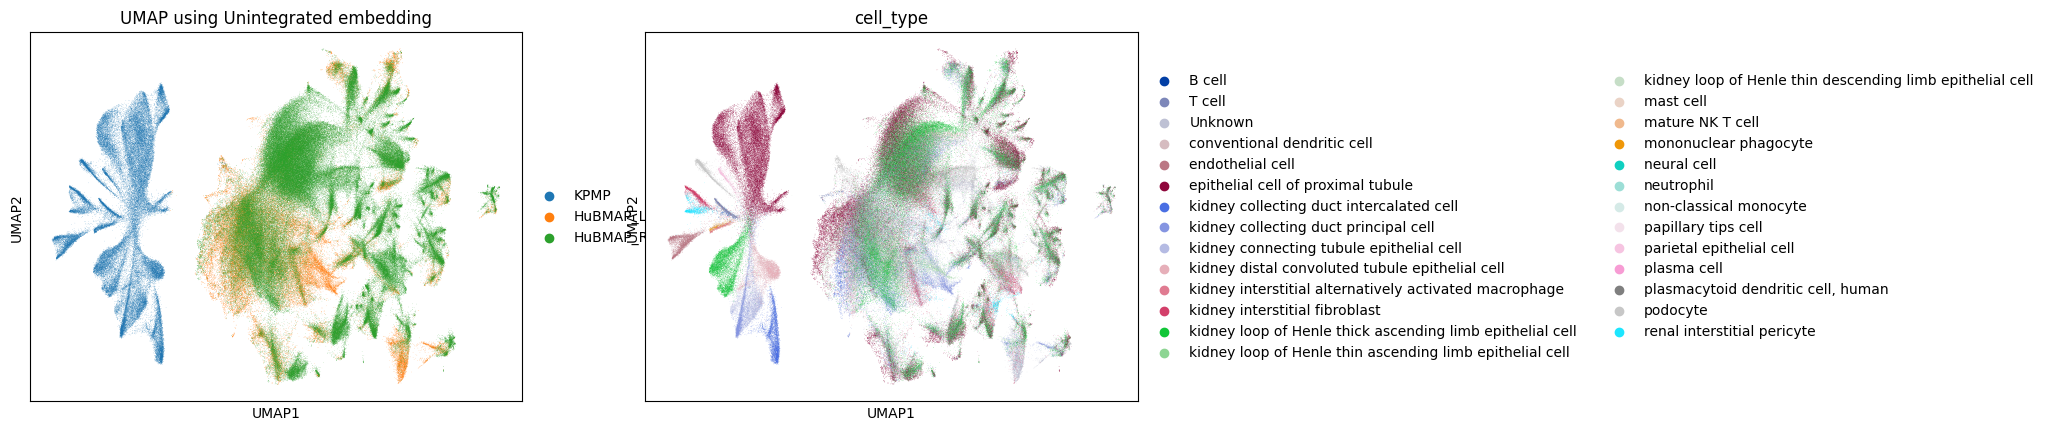

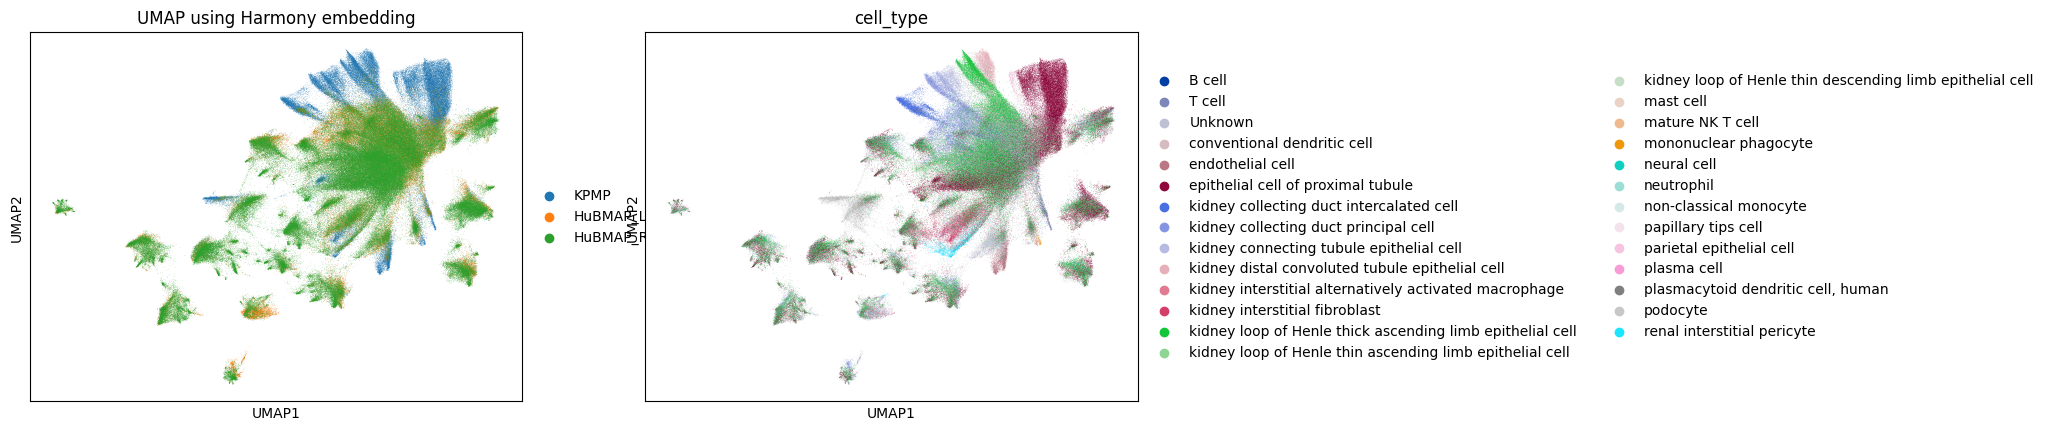

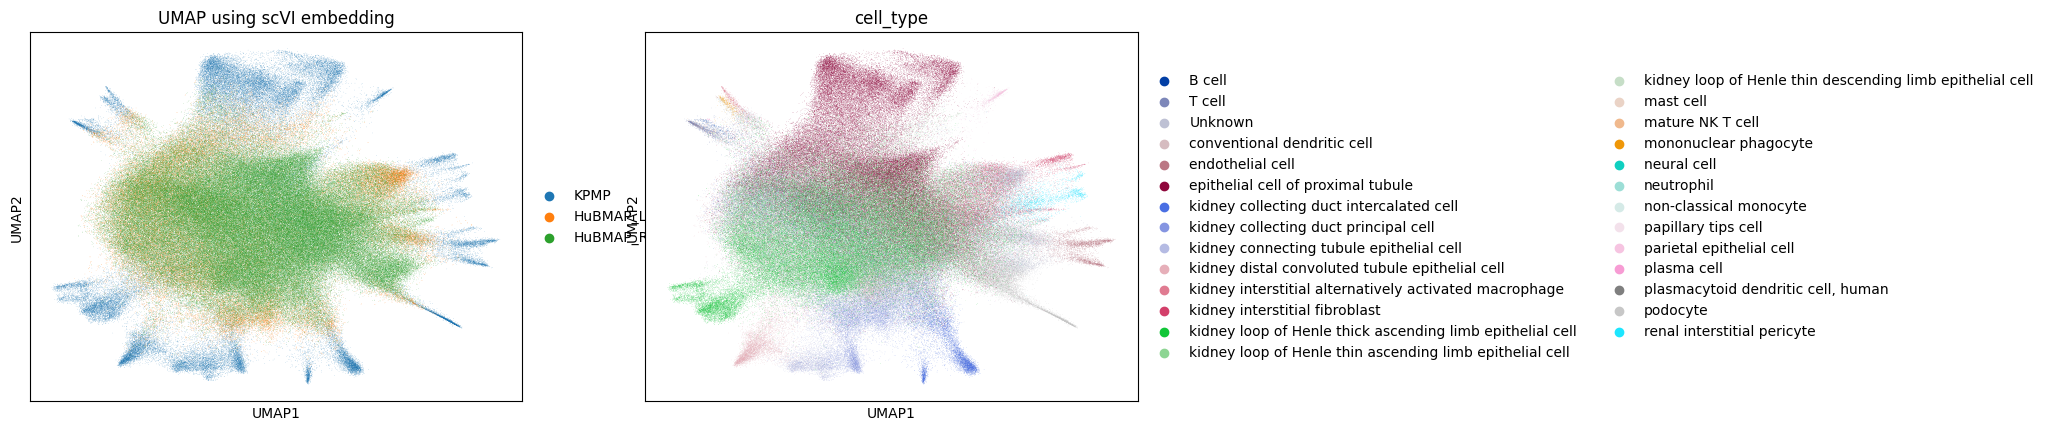

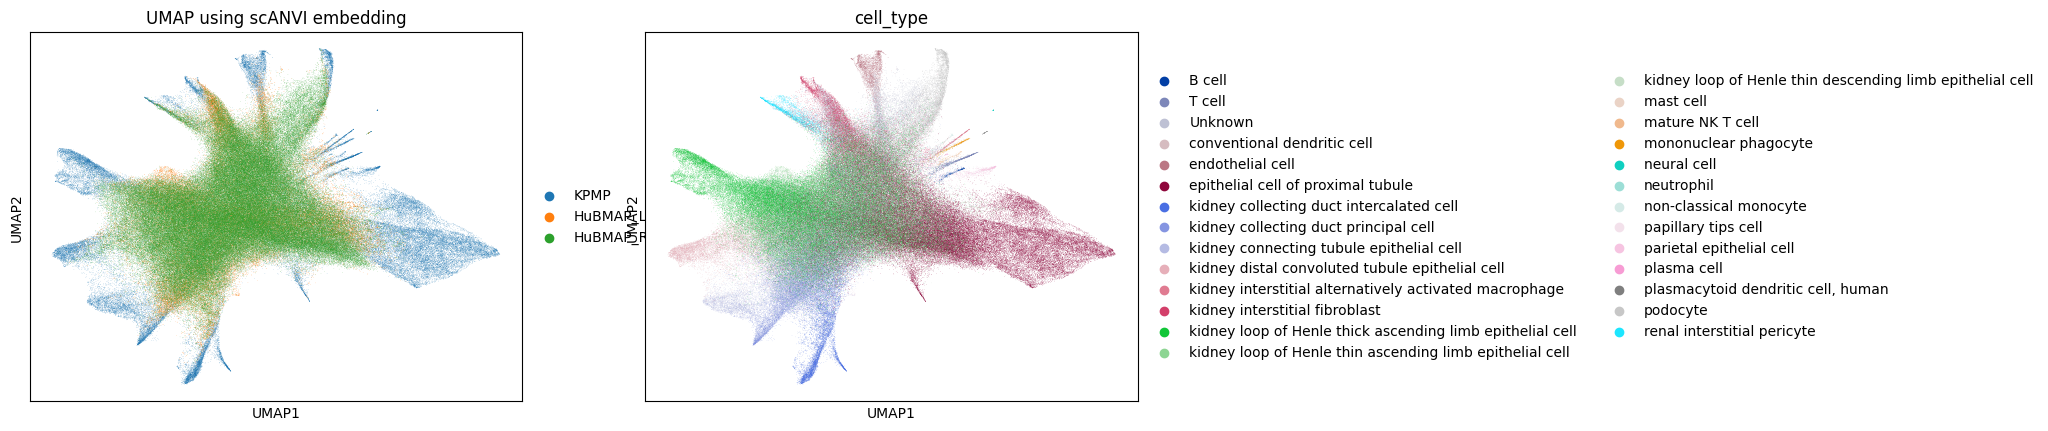

In [41]:
for key in ["Unintegrated", "Harmony", "scVI", "scANVI"]:
    neighbors_key = f'neighbors_{key}'
    umap_key = f'X_umap_{key}'
    sc.pp.neighbors(adata_combined, use_rep=key,key_added=neighbors_key)
    sc.tl.leiden(adata_combined, neighbors_key=neighbors_key)
    sc.tl.umap(adata_combined, neighbors_key=neighbors_key,min_dist=0.3, key_added=umap_key)
    adata_combined.obsm["X_umap"] = adata_combined.obsm[umap_key]
    sc.pl.umap(
        adata_combined,
        title=f"UMAP using {key} embedding",
        save=f"M2_Umap_{key}.png",
        color=['batch_combine','cell_type']
    )

In [42]:
adata_combined.write('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/M2-git-kpmp-hubmap-cortex-normal-3000-hvg.h5ad')

In [ ]:
adata_combined=sc.read('/scratch/yongqunh_root/yongqunh0/wruopeng/HuBMAP_KPMP/M2-git-kpmp-hubmap-cortex-normal-3000-hvg.h5ad')

In [5]:
adata_combined

AnnData object with n_obs × n_vars = 372163 × 3000
    obs: 'library_id', 'cell_type', 'disease', 'sex', 'batch_combine', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_symbol', 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'X_umap_Harmony', 'X_umap_Unintegrated', 'X_umap_scANVI', 'X_umap_scVI', '_scvi_manager_uuid', '_scvi_uuid', 'batch_combine_colors', 'cell_type_colors', 'hvg', 'leiden', 'log1p', 'neighbors_Harmony', 'neighbors_Unintegrated', 'neighbors_scANVI', 'neighbors_scVI', 'pca'
    obsm: 'Harmony', 'Unintegrated', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_Harmony', 'X_umap_Unintegrated', 'X_umap_scANVI', 'X_umap_scVI', '_scvi_extra_categorical_covs', 'scANVI', 'scVI'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'neighbors_Harmony_connectivities', 'neighbors_Harmony_distances', 'neighbors_Unintegrated_connectivities', 'neighbors_Unintegrated_di

In [31]:
def Umap_checking(umap_key):
    adata_combined.obsm["X_umap"] = adata_combined.obsm[f"X_umap_{umap_key}"]
    
    sc.pl.umap(
        adata_combined,
        color="batch_combine",  
        size=8
    )
    
    batch_palette = {"KPMP":"#1f77b4","HuBMAP_LK":"#ff7f0e","HuBMAP_RK":"#2ca02c"}

    # Transparent background: all points
    sc.pl.umap(
        adata_combined,
        color="batch_combine",
        palette=batch_palette,
        alpha=0.15,
        size=10,
        show=False,
        ax=ax
    )
    
    adata_kpmp = adata_combined[adata_combined.obs["batch_combine"] == "KPMP"].copy()

    sc.pl.umap(
        adata_kpmp,
        color="batch_combine",   # or any other column you want
        size=8
    )
    adata_hubmap = adata_combined[adata_combined.obs["batch_combine"].isin(["HuBMAP_LK"])].copy()

    sc.pl.umap(
        adata_hubmap,
        color="batch_combine",   # or any other column you want
        size=8
    )
    adata_hubmap = adata_combined[adata_combined.obs["batch_combine"].isin(["HuBMAP_RK"])].copy()

    sc.pl.umap(
        adata_hubmap,
        color="batch_combine",   # or any other column you want
        size=8
    )

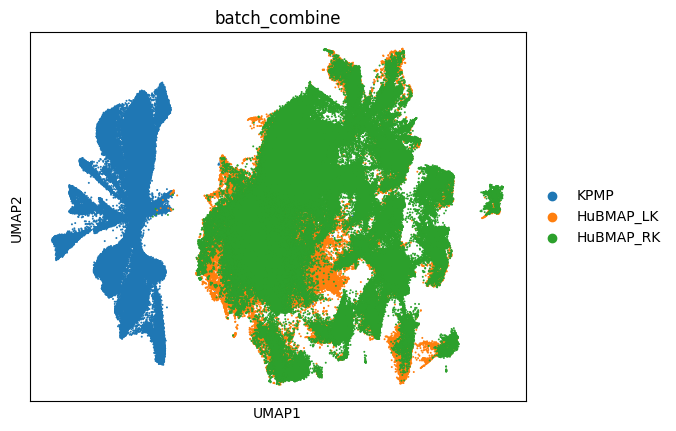

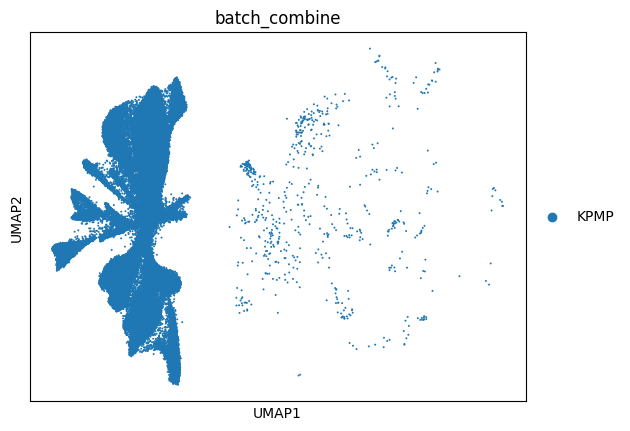

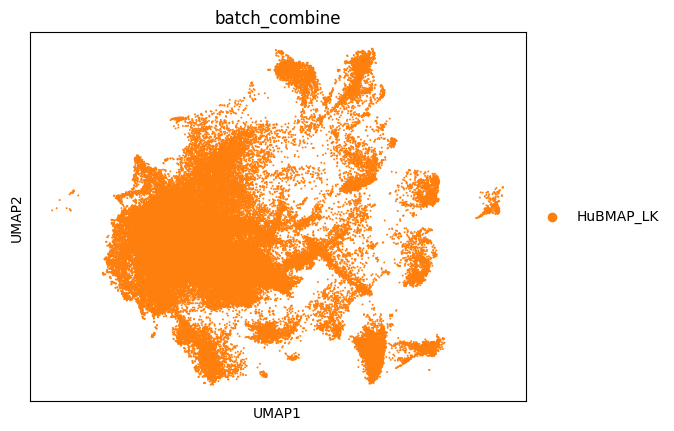

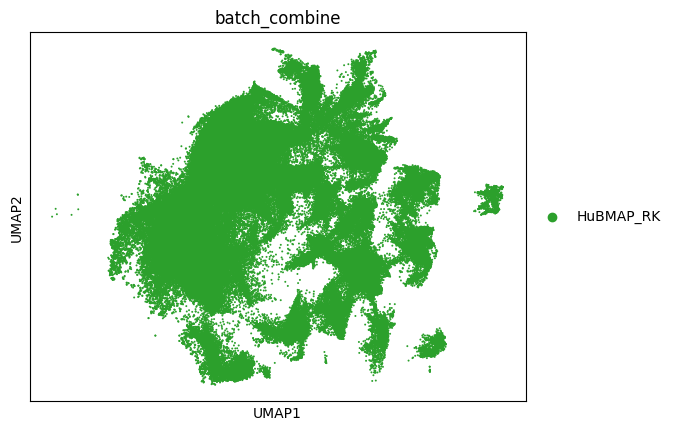

In [36]:
Umap_checking('Unintegrated')

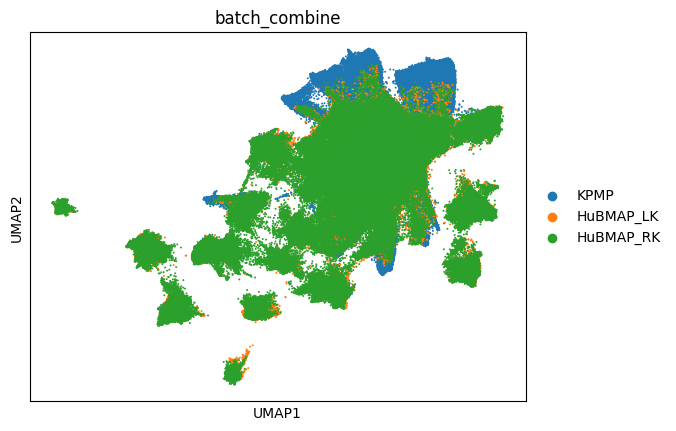

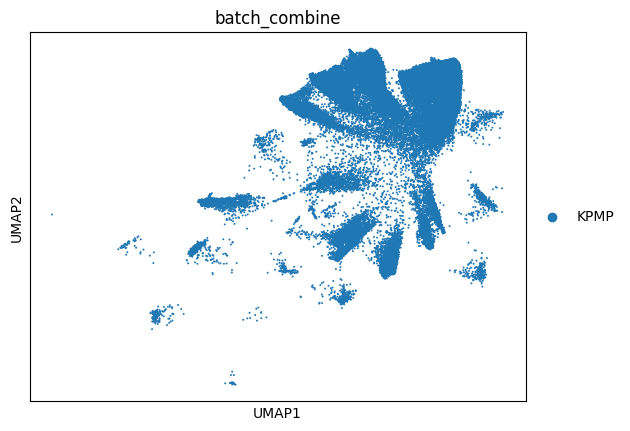

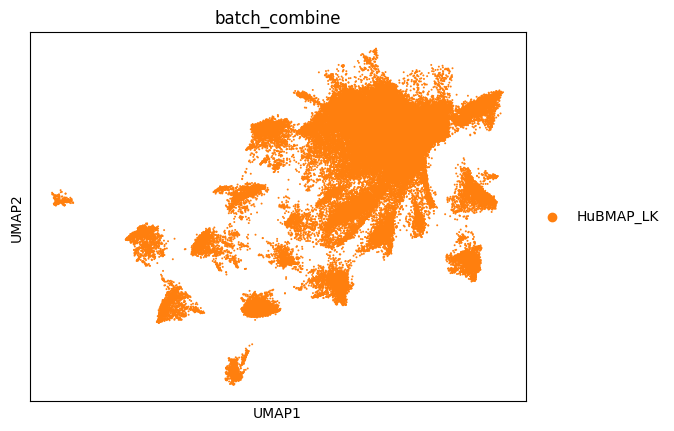

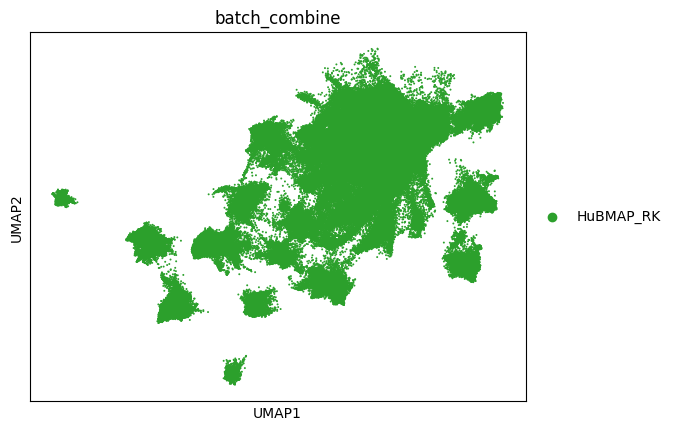

In [33]:
Umap_checking('Harmony')

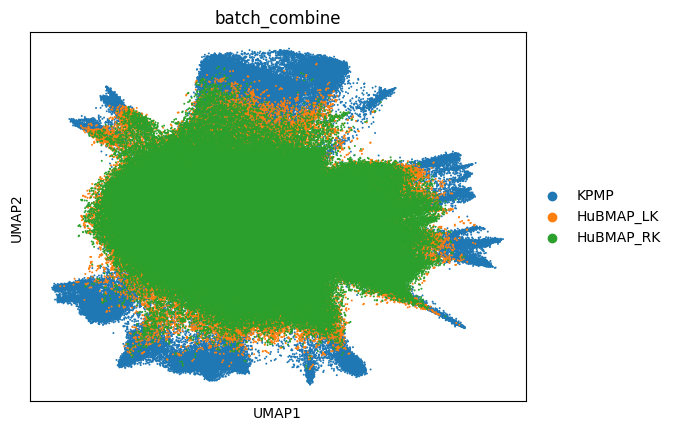

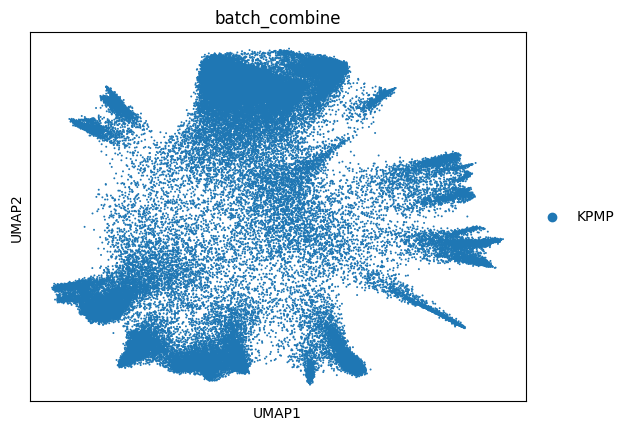

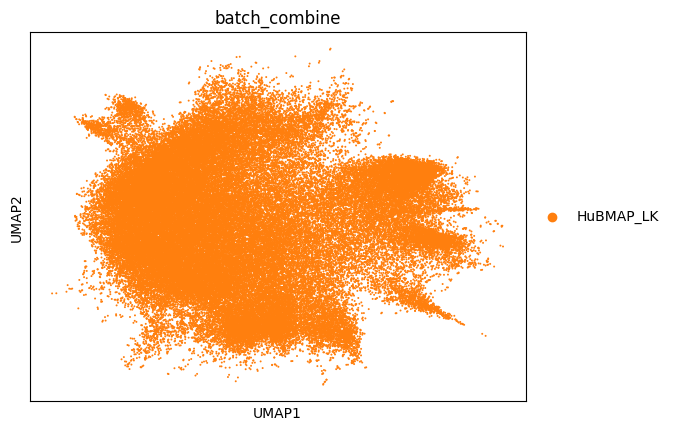

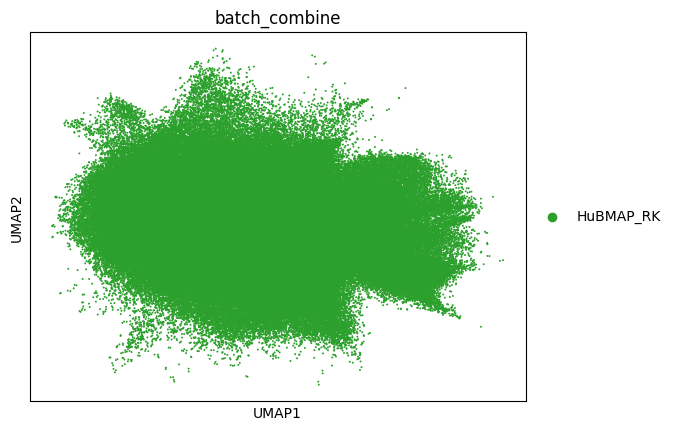

In [34]:
Umap_checking('scVI')

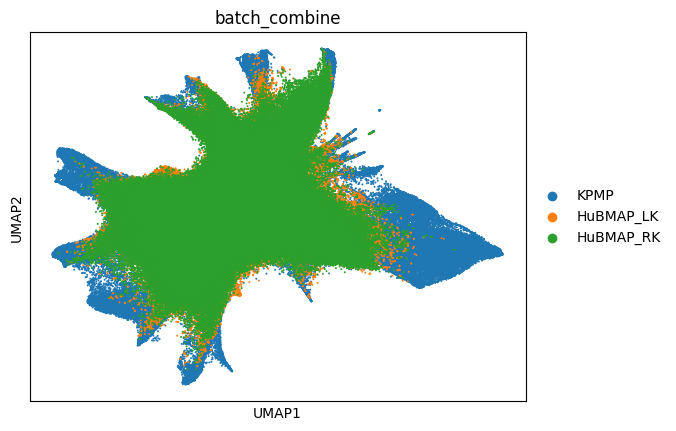

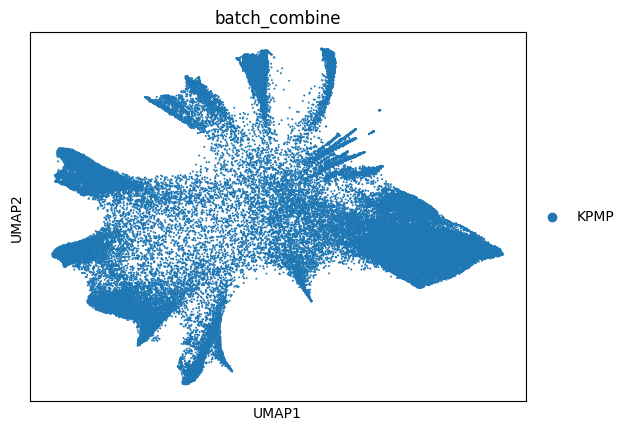

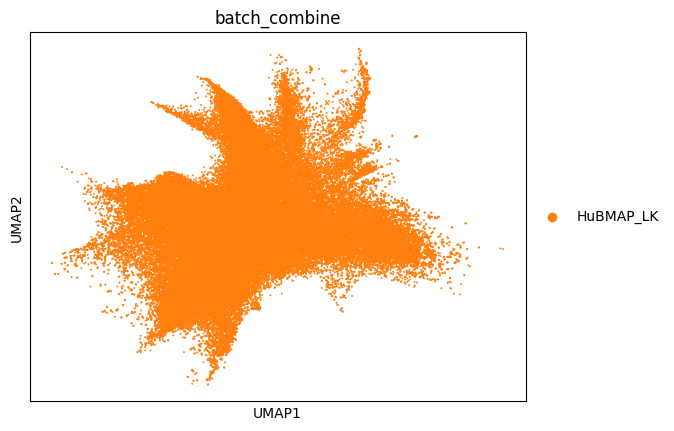

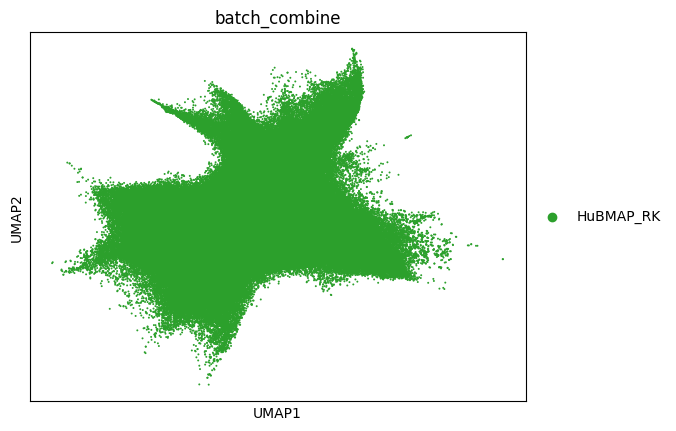

In [35]:
Umap_checking('scANVI')

<Axes: title={'center': 'batch_combine'}, xlabel='UMAP1', ylabel='UMAP2'>

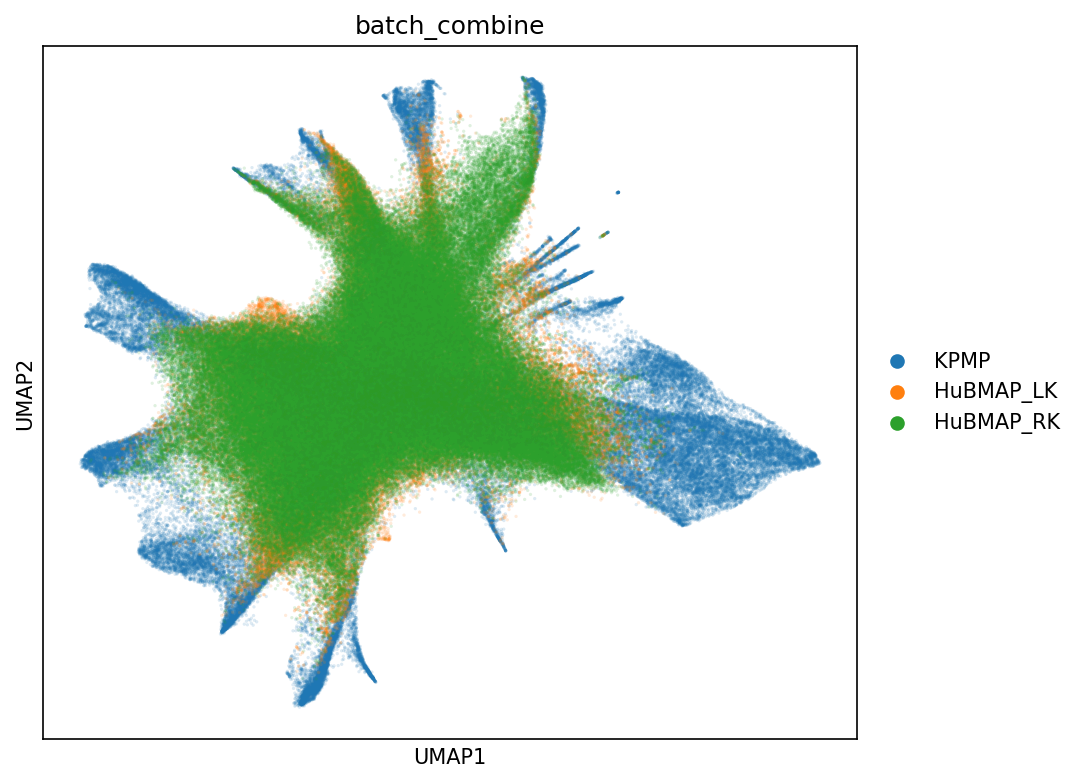

In [13]:
batch_palette = {"KPMP":"#1f77b4","HuBMAP_LK":"#ff7f0e","HuBMAP_RK":"#2ca02c"}

fig, ax = plt.subplots(figsize=(7, 6), dpi=150)

# Transparent background: all points
sc.pl.umap(
    adata_combined,
    color="batch_combine",
    palette=batch_palette,
    alpha=0.15,
    size=10,
    show=False,
    ax=ax
)


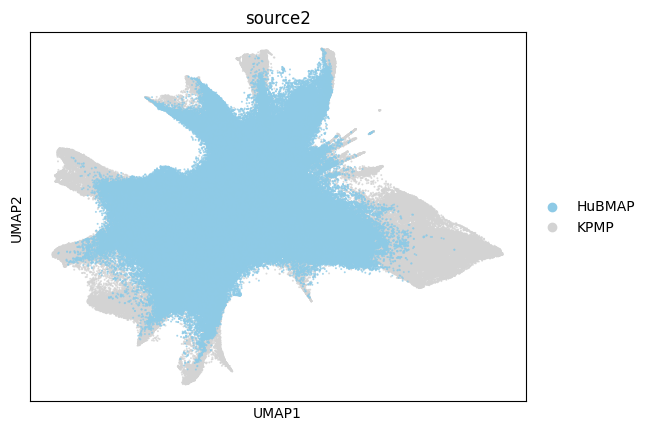

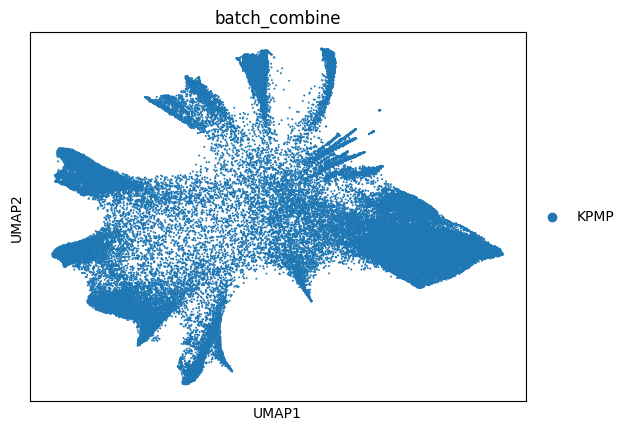

In [20]:
adata_combined.obs["source2"] = np.where(
    adata_combined.obs["batch_combine"] == "KPMP",
    "KPMP",
    "HuBMAP"
)

# 2) inverse colors: KPMP grey, HuBMAP light color
sc.pl.umap(
    adata_combined,
    color="source2",
    palette={"KPMP": "lightgrey", "HuBMAP": "#8ecae6"},  # light blue
    size=8,
    alpha=0.8
)


adata_kpmp = adata_combined[adata_combined.obs["batch_combine"] == "KPMP"].copy()

sc.pl.umap(
    adata_kpmp,
    color="batch_combine",   # or any other column you want
    size=8
)

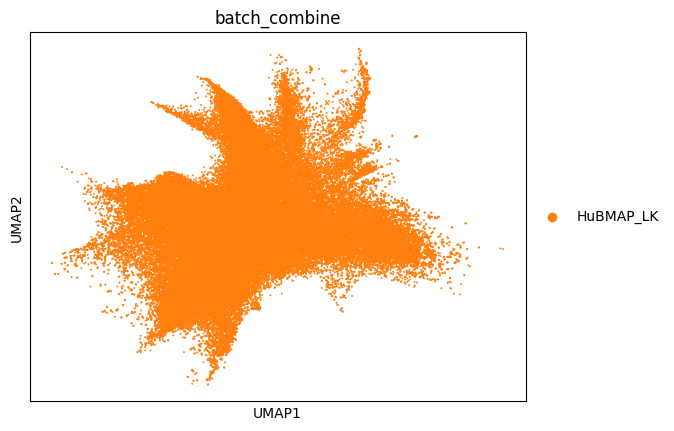

In [22]:

adata_hubmap = adata_combined[adata_combined.obs["batch_combine"].isin(["HuBMAP_LK"])].copy()

sc.pl.umap(
    adata_hubmap,
    color="batch_combine",   # or any other column you want
    size=8
)